In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from census import Census
from us import states
import os
import numpy as np

In [2]:
api_key = #insert your API key here
c = Census(api_key)

## Tutorial Section

This chunk is working through a tutorial. The original version is using VA data, but I modified to use MD data. This all works, if you have the shapefiles downloaded locally, but I'm fuzzy on the details of how I fixed that... :(

In [3]:
# Obtain Census variables from the 2019 ACS at the tract level for the Commonwealth of Virginia (FIPS code: 51)
# C17002_001E: count of ratio of income to poverty in the past 12 months (total)
# C17002_002E: count of ratio of income to poverty in the past 12 months (< 0.50)
# C17002_003E: count of ratio of income to poverty in the past 12 months (0.50 - 0.99)
# B01003_001E: total population
# Sources: https://api.census.gov/data/2019/acs/acs5/variables.html; https://pypi.org/project/census/
MD_census = c.acs5.state_county_tract(fields = ('NAME', 'C17002_001E', 'C17002_002E', 'C17002_003E', 'B01003_001E'),
                                      state_fips = states.MD.fips,
                                      county_fips = "*",
                                      tract = "*",
                                      year = 2023)

In [7]:
md_df = pd.DataFrame(MD_census)

print(md_df.head(10))
print("Shape:", md_df.shape)

                                         NAME  C17002_001E  C17002_002E  \
0   Census Tract 1; Allegany County; Maryland       3144.0        124.0   
1   Census Tract 2; Allegany County; Maryland       3031.0         98.0   
2   Census Tract 5; Allegany County; Maryland       1864.0        327.0   
3   Census Tract 6; Allegany County; Maryland       2730.0        131.0   
4   Census Tract 7; Allegany County; Maryland       3340.0        282.0   
5   Census Tract 8; Allegany County; Maryland       1968.0        345.0   
6  Census Tract 10; Allegany County; Maryland       1832.0        425.0   
7  Census Tract 11; Allegany County; Maryland       1411.0        127.0   
8  Census Tract 12; Allegany County; Maryland       2861.0         81.0   
9  Census Tract 13; Allegany County; Maryland       2117.0         96.0   

   C17002_003E  B01003_001E state county   tract  
0        173.0       3153.0    24    001  000100  
1        266.0       4094.0    24    001  000200  
2        201.0       

The rest of this is tutorial, but you don't need to run it to get the demographic information

In [190]:
# print(states.MD.fips)

# Access shapefile of Maryland census tracts
md_tract = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2024/TRACT/tl_2024_24_tract.zip")

# Reproject shapefile to UTM Zone 18N
# https://spatialreference.org/ref/epsg/wgs-84-utm-zone-18n/
md_tract = md_tract.to_crs(epsg = 32618)

# Print GeoDataFrame of shapefile
print(md_tract.head(2))
print('Shape: ', md_tract.shape)

# Check shapefile projection
print("\nThe shapefile projection is: {}".format(md_tract.crs))

C:\Users\rebek\anaconda3\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: HTTP response code on https://www2.census.gov/geo/tiger/TIGER2024/TRACT/tl_2024_24_tract.zip: 0
  return ogr_read(


DataSourceError: '/vsizip/vsicurl/https://www2.census.gov/geo/tiger/TIGER2024/TRACT/tl_2024_24_tract.zip' does not exist in the file system, and is not recognized as a supported dataset name.

In [34]:
md_tract['GEOID']  = md_tract['STATEFP'] + md_tract['COUNTYFP'] + md_tract['TRACTCE']
md_df['GEOID'] = md_df['state'] + md_df['county'] + md_df['tract']

print(md_tract.head(6).sort_values(by=['GEOID']))
print(md_df.head(6).sort_values(by=['GEOID']))

     STATEFP COUNTYFP TRACTCE        GEOID NAME        NAMELSAD  MTFCC  \
110       24      043  000100  24043000100    1  Census Tract 1  G5020   
245       24      023  000100  24023000100    1  Census Tract 1  G5020   
447       24      001  000100  24001000100    1  Census Tract 1  G5020   
1250      24      045  000100  24045000100    1  Census Tract 1  G5020   

     FUNCSTAT      ALAND   AWATER     INTPTLAT      INTPTLON  \
110         S    1849870        0  +39.6554853  -077.6999156   
245         S  272890739  2682974  +39.6403643  -079.3770543   
447         S  486755796  7821335  +39.6365143  -078.5094487   
1250        S    3151344    18068  +38.3718951  -075.5828034   

                                               geometry  
110   POLYGON ((2.67e+05 4.39e+06, 2.67e+05 4.39e+06...  
245   POLYGON ((1.15e+05 4.39e+06, 1.15e+05 4.39e+06...  
447   POLYGON ((1.85e+05 4.4e+06, 1.85e+05 4.4e+06, ...  
1250  POLYGON ((4.48e+05 4.25e+06, 4.48e+05 4.25e+06...  
                  

In [36]:
#Okay, this shouldn't merge, but maybe it does because shapefiles are weird?
# Check column data types for census data
print("Column data types for census data:\n{}".format(md_df.dtypes))

# Check column data types for census shapefile
print("\nColumn data types for census shapefile:\n{}".format(md_tract.dtypes))

# Source: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dtypes.html

Column data types for census data:
NAME            object
C17002_001E    float64
C17002_002E    float64
C17002_003E    float64
B01003_001E    float64
state           object
county          object
tract           object
GEOID           object
dtype: object

Column data types for census shapefile:
STATEFP       object
COUNTYFP      object
TRACTCE       object
GEOID         object
NAME          object
NAMELSAD      object
MTFCC         object
FUNCSTAT      object
ALAND          int64
AWATER         int64
INTPTLAT      object
INTPTLON      object
geometry    geometry
dtype: object


In [74]:
md_merge = md_tract.merge(md_df, on = "GEOID", how = "outer")

print(md_merge.head(6))
print('Shape: ', md_merge.shape)

  STATEFP COUNTYFP TRACTCE        GEOID NAME_x        NAMELSAD  MTFCC  \
0      24      001  000100  24001000100      1  Census Tract 1  G5020   
1      24      001  000200  24001000200      2  Census Tract 2  G5020   
2      24      001  000300  24001000300      3  Census Tract 3  G5020   
3      24      001  000400  24001000400      4  Census Tract 4  G5020   
4      24      001  000500  24001000500      5  Census Tract 5  G5020   
5      24      001  000600  24001000600      6  Census Tract 6  G5020   

  FUNCSTAT        ALAND     AWATER  ...      INTPTLON  \
0        S  486755796.0  7821335.0  ...  -078.5094487   
1        S  124508288.0  3080200.0  ...  -078.7031037   
2        S   22375901.0     5874.0  ...  -078.7441413   
3        S    9642972.0    61044.0  ...  -078.7270568   
4        S   11451817.0   157507.0  ...  -078.7294891   
5        S    4098568.0    70648.0  ...  -078.7398353   

                                            geometry  \
0  POLYGON ((1.85e+05 4.4e+06, 1

In [76]:
# Create new dataframe from select columns
md_poverty_tract = md_merge[["STATEFP", "COUNTYFP", "TRACTCE", "GEOID", "geometry", "C17002_001E", "C17002_002E", "C17002_003E", "B01003_001E"]]

# Show dataframe
print(md_poverty_tract.head(2))
print('Shape: ', md_poverty_tract.shape)

  STATEFP COUNTYFP TRACTCE        GEOID  \
0      24      001  000100  24001000100   
1      24      001  000200  24001000200   

                                            geometry  C17002_001E  \
0  POLYGON ((1.85e+05 4.4e+06, 1.85e+05 4.4e+06, ...       3144.0   
1  POLYGON ((1.76e+05 4.39e+06, 1.76e+05 4.39e+06...       3031.0   

   C17002_002E  C17002_003E  B01003_001E  
0        124.0        173.0       3153.0  
1         98.0        266.0       4094.0  
Shape:  (1596, 9)


In [78]:
# Dissolve and group the census tracts within each county and aggregate all the values together
# Source: https://geopandas.org/docs/user_guide/aggregation_with_dissolve.html
md_poverty_county = md_poverty_tract.dissolve(by = 'COUNTYFP', aggfunc = 'sum')

# Show dataframe
print(md_poverty_county.head(2))
print('Shape: ', md_poverty_county.shape)

                                                   geometry  \
COUNTYFP                                                      
001       POLYGON ((1.5e+05 4.38e+06, 1.5e+05 4.38e+06, ...   
003       POLYGON ((3.59e+05 4.29e+06, 3.59e+05 4.29e+06...   

                                                    STATEFP  \
COUNTYFP                                                      
001          2424242424242424242424242424242424242424242424   
003       2424242424242424242424242424242424242424242424...   

                                                    TRACTCE  \
COUNTYFP                                                      
001       0001000002000003000004000005000006000007000008...   
003       7011017011027012007013007014007021007022047022...   

                                                      GEOID  C17002_001E  \
COUNTYFP                                                                   
001       2400100010024001000200240010003002400100040024...      55734.0   
003       240

In [80]:
# Get poverty rate and store values in new column
md_poverty_county["Poverty_Rate"] = (md_poverty_county["C17002_002E"] + md_poverty_county["C17002_003E"]) / md_poverty_county["B01003_001E"] * 100

# Show dataframe
md_poverty_county.head(2)

,geometry,STATEFP,TRACTCE,GEOID,C17002_001E,C17002_002E,C17002_003E,B01003_001E,Poverty_Rate
COUNTYFP,,,,,,,,,
001,"POLYGON ((1.5e+05 4.38e+06, 1.5e+05 4.38e+06, ...",2424242424242424242424242424242424242424242424,0001000002000003000004000005000006000007000008...,2400100010024001000200240010003002400100040024...,55734.0,4203.0,5331.0,62202.0,15.327481
003,"POLYGON ((3.59e+05 4.29e+06, 3.59e+05 4.29e+06...",2424242424242424242424242424242424242424242424...,7011017011027012007013007014007021007022047022...,2400370110124003701102240037012002400370130024...,383034.0,11505.0,7553.0,391662.0,4.865930


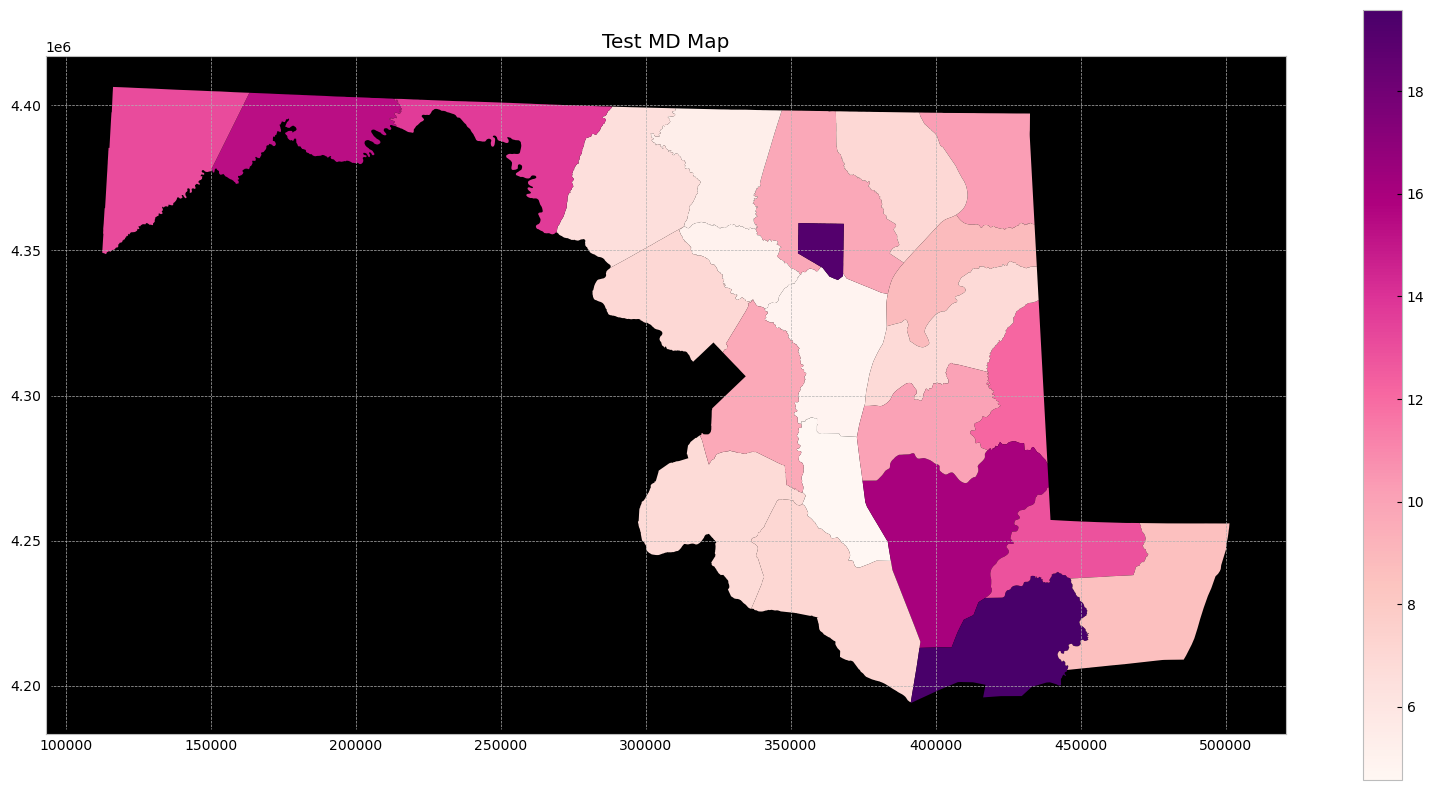

In [84]:
#Plotting to see if this works?
fig,ax = plt.subplots(1,1,figsize= (20,10))

md_poverty_county.plot(column = "Poverty_Rate",
              ax = ax,
              cmap = "RdPu",
              legend = True)
plt.style.use('bmh')
ax.set_title('Test MD Map')
ax.set_facecolor('xkcd:black')

## Maryland Demographic Information - Census Data

Okay, this is a chance to play with markdown, and also document some of the variables that we want to pull from the census.

Metadata:   
- Number of Total designated census areas
- Non-null entries for each data point

Total Population: B01001_001E and B01003_001E (compare both - they seem to say similar things on the census webpage - that they're total population, but seem to be headers for different demographic cuts?) (Also B02001_001E)

Male: B01001_002E

Female: B01001_026E

Registered Voters: N/A
Census does not have voting or party information, but Michelle includes it

Ages: 
- (0-4): B01001_003E (male) + B01001_027E (female)
- (5-9): B01001_004E (male) + B01001_028E (female)
- (10-19): B01001_005E + B01001_006E + B01001_007E (male) + B01001_029E + B01001_030E + B01001_031E (female)
- (20-29): B01001_008E + B01001_009E + B01001_010E + B01001_011E (male) + B01001_032E + B01001_033E + B01001_034E + B01001_035E (female)
- (30-39): B01001_012E + B01001_013E (male) + B01001_036E + B01001_037E (female)  
- (40-49): B01001_014E + B01001_015E (male) + B01001_038E + B01001_039E (female)  
- (50-59): B01001_016E + B01001_017E (male) + B01001_040E + B01001_041E (female) 
- (60-64): B01001_018E + B01001_019E (male) + B01001_042E + B01001_043E (female) 
- (65+): B01001_020E + B01001_021E + B01001_022E + B01001_023E + B01001_024E + B01001_025E (male) + B01001_044E + B01001_045E + B01001_046E + B01001_047E + B01001_048E + B01001_049E 

Race/Ethnicity: 
- White: B02001_002E
- Black: B02001_003E
- American Indian: B02001_004E
- Asian: B02001_005E
- Pacific Islander: B02001_006E
- Other: B02001_007E
- Multirace: B02001_008E (is this total? - check if sum of B02001_009E and B02001_010E)
- Hispanic/Latino: B03001_003E

In [192]:
MD_census_demo = c.acs5.state_county_tract(fields = ('NAME', 'B01001_001E', 'B01003_001E', 'B01001_002E', 'B01001_026E', 'B01001_003E','B01001_027E','B01001_004E',
                                                   'B01001_028E','B01001_005E','B01001_006E','B01001_007E','B01001_029E','B01001_030E','B01001_031E','B01001_008E',
                                                   'B01001_009E','B01001_010E','B01001_011E','B01001_032E','B01001_033E','B01001_034E','B01001_035E','B01001_012E',
                                                   'B01001_013E','B01001_036E','B01001_037E','B01001_014E','B01001_015E','B01001_038E','B01001_039E','B01001_016E',
                                                   'B01001_017E','B01001_040E','B01001_041E','B01001_018E','B01001_019E','B01001_042E','B01001_043E','B01001_020E',
                                                   'B01001_021E','B01001_022E','B01001_023E','B01001_024E','B01001_025E','B01001_044E','B01001_045E','B01001_046E',
                                                   'B01001_047E','B01001_048E','B01001_049E','B02001_002E','B02001_003E','B02001_004E','B02001_005E','B02001_006E',
                                                   'B02001_007E','B02001_008E','B02001_009E','B02001_010E','B03001_003E'),
                                      state_fips = states.MD.fips,
                                      county_fips = "*",
                                      tract = "*",
                                      year = 2023)

In [6]:
census_df_raw = pd.DataFrame(MD_census_demo)

census_df_raw.rename(columns = {"B01001_001E":"total",
                            "B01003_001E":"total_check",
                            "B01001_002E":"gender_male",
                            "B01001_026E":"gender_female",
                            "B01001_003E":"age_0-4(M)",
                            "B01001_027E":"age_0-4(F)",
                            "B01001_004E":"age_5-9(M)",
                            "B01001_028E":"age_5-9(F)",
                            "B01001_005E":"age_10-19(M)_1", "B01001_006E":"age_10-19(M)_2", "B01001_007E":"age_10-19(M)_3",
                            "B01001_029E":"age_10-19(F)_1", "B01001_030E":"age_10-19(F)_2", "B01001_031E":"age_10-19(F)_3",
                            "B01001_008E":"age_20-29(M)_1", "B01001_009E":"age_20-29(M)_2", "B01001_010E":"age_20-29(M)_3", "B01001_011E":"age_20-29(M)_4",
                            "B01001_032E":"age_20-29(F)_1", "B01001_033E":"age_20-29(F)_2", "B01001_034E":"age_20-29(F)_3", "B01001_035E":"age_20-29(F)_4",
                            "B01001_012E":"age_30-39(M)_1", "B01001_013E":"age_30-39(M)_2",
                            "B01001_036E":"age_30-39(F)_1", "B01001_037E":"age_30-39(F)_2",
                            "B01001_014E":"age_40-49(M)_1", "B01001_015E":"age_40-49(M)_2",
                            "B01001_038E":"age_40-49(F)_1", "B01001_039E":"age_40-49(F)_2",
                            "B01001_016E":"age_50-59(M)_1", "B01001_017E":"age_50-59(M)_2",
                            "B01001_040E":"age_50-59(F)_1", "B01001_041E":"age_50-59(F)_2",
                            "B01001_018E":"age_60-64(M)_1", "B01001_019E":"age_60-64(M)_2",
                            "B01001_042E":"age_60-64(F)_1", "B01001_043E":"age_60-64(F)_2",
                            "B01001_020E":"age_65+(M)_1", "B01001_021E":"age_65+(M)_2", "B01001_022E":"age_65+(M)_3", "B01001_023E":"age_65+(M)_4", "B01001_024E":"age_65+(M)_5", "B01001_025E":"age_65+(M)_6",
                            "B01001_044E":"age_65+(F)_1", "B01001_045E":"age_65+(F)_2", "B01001_046E":"age_65+(F)_3", "B01001_047E":"age_65+(F)_4", "B01001_048E":"age_65+(F)_5", "B01001_049E":"age_65+(F)_6",
                            "B02001_002E":"race_white",
                            "B02001_003E":"race_black",
                            "B02001_004E":"race_american_indian",
                            "B02001_005E":"race_asian",
                            "B02001_006E":"race_pacific_islander",
                            "B02001_007E":"race_other",
                            "B02001_008E":"race_multirace", "B02001_009E":"multirace_check1", "B02001_010E":"multirace_check2",
                            "B03001_003E":"ethnic_hispanic"}, inplace = True)
                            
print(census_df_raw.head(10))
print("Shape:", census_df_raw.shape)
print(census_df_raw.columns)

                                         NAME   total  total_check  \
0   Census Tract 1; Allegany County; Maryland  3153.0       3153.0   
1   Census Tract 2; Allegany County; Maryland  4094.0       4094.0   
2   Census Tract 5; Allegany County; Maryland  2269.0       2269.0   
3   Census Tract 6; Allegany County; Maryland  2829.0       2829.0   
4   Census Tract 7; Allegany County; Maryland  3377.0       3377.0   
5   Census Tract 8; Allegany County; Maryland  1972.0       1972.0   
6  Census Tract 10; Allegany County; Maryland  1859.0       1859.0   
7  Census Tract 11; Allegany County; Maryland  1423.0       1423.0   
8  Census Tract 12; Allegany County; Maryland  2950.0       2950.0   
9  Census Tract 13; Allegany County; Maryland  5030.0       5030.0   

   gender_male  gender_female  age_0-4(M)  age_0-4(F)  age_5-9(M)  age_5-9(F)  \
0       1688.0         1465.0        88.0        27.0       130.0        78.0   
1       2609.0         1485.0        82.0        58.0        64.0  

In [9]:
census_df = census_df_raw.T.groupby([c.split('(')[0] for c in census_df_raw.columns]).sum().T
print(census_df.head(10))
print(census_df.shape)
print(census_df.columns)

                 GEO_ID                                        NAME age_0-4  \
0  1400000US24001000100   Census Tract 1; Allegany County; Maryland   115.0   
1  1400000US24001000200   Census Tract 2; Allegany County; Maryland   140.0   
2  1400000US24001000500   Census Tract 5; Allegany County; Maryland    28.0   
3  1400000US24001000600   Census Tract 6; Allegany County; Maryland    94.0   
4  1400000US24001000700   Census Tract 7; Allegany County; Maryland   137.0   
5  1400000US24001000800   Census Tract 8; Allegany County; Maryland   181.0   
6  1400000US24001001000  Census Tract 10; Allegany County; Maryland    78.0   
7  1400000US24001001100  Census Tract 11; Allegany County; Maryland    15.0   
8  1400000US24001001200  Census Tract 12; Allegany County; Maryland    86.0   
9  1400000US24001001300  Census Tract 13; Allegany County; Maryland    37.0   

  age_10-19 age_20-29 age_30-39 age_40-49 age_5-9 age_50-59 age_60-64  ...  \
0     253.0     152.0     401.0     406.0   208.0   

In [11]:
sum(census_df['race_white'] != census_df['race_black'])

1460

Okay, I did a basic check on this - it seems like all people either fall into a male or female category, and the total categories from different fields seem to match. Multiracial categories is the sum of 2 races and 3+ races, so this data looks pretty sensible, so we're going to keep working on this data

In [13]:
# Access shapefile of Maryland census tracts
md_tract = gpd.read_file("MD Tracts/tl_2024_24_tract.shp")

# Reproject shapefile to UTM Zone 18N
# https://spatialreference.org/ref/epsg/wgs-84-utm-zone-18n/
md_tract = md_tract.to_crs(epsg = 32618)

# Print GeoDataFrame of shapefile
print(md_tract.head(2))
print('Shape: ', md_tract.shape)

# Check shapefile projection
print("\nThe shapefile projection is: {}".format(md_tract.crs))

  STATEFP COUNTYFP TRACTCE        GEOID               GEOIDFQ     NAME  \
0      24      005  403100  24005403100  1400000US24005403100     4031   
1      24      005  403201  24005403201  1400000US24005403201  4032.01   

               NAMELSAD  MTFCC FUNCSTAT    ALAND  AWATER     INTPTLAT  \
0     Census Tract 4031  G5020        S  1913598       0  +39.3530950   
1  Census Tract 4032.01  G5020        S  1764534       0  +39.3549038   

       INTPTLON                                           geometry  
0  -076.7333148  POLYGON ((3.5e+05 4.36e+06, 3.5e+05 4.36e+06, ...  
1  -076.7215235  POLYGON ((3.51e+05 4.36e+06, 3.51e+05 4.36e+06...  
Shape:  (1475, 14)

The shapefile projection is: EPSG:32618


In [15]:
md_tract['GEOID']  = md_tract['STATEFP'] + md_tract['COUNTYFP'] + md_tract['TRACTCE']
census_df['GEOID'] = census_df['state'] + census_df['county'] + census_df['tract']

print(md_tract.sort_values(by=['GEOID']).head(6))
print(census_df.sort_values(by=['GEOID']).head(6))

    STATEFP COUNTYFP TRACTCE        GEOID               GEOIDFQ NAME  \
404      24      001  000100  24001000100  1400000US24001000100    1   
402      24      001  000200  24001000200  1400000US24001000200    2   
414      24      001  000500  24001000500  1400000US24001000500    5   
411      24      001  000600  24001000600  1400000US24001000600    6   
395      24      001  000700  24001000700  1400000US24001000700    7   
403      24      001  000800  24001000800  1400000US24001000800    8   

           NAMELSAD  MTFCC FUNCSTAT      ALAND   AWATER     INTPTLAT  \
404  Census Tract 1  G5020        S  486743629  7770938  +39.6365143   
402  Census Tract 2  G5020        S  124505958  3080200  +39.6123134   
414  Census Tract 5  G5020        S   11455399   157507  +39.6546637   
411  Census Tract 6  G5020        S    4098567    70648  +39.6409546   
395  Census Tract 7  G5020        S    1844978        0  +39.6329587   
403  Census Tract 8  G5020        S    3271526   408357  +39.62

In [17]:
# Check column data types for census data
print("Column data types for census data:\n{}".format(census_df.dtypes))

# Check column data types for census shapefile
print("\nColumn data types for census shapefile:\n{}".format(md_tract.dtypes))



# Source: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dtypes.html

Column data types for census data:
GEO_ID                   object
NAME                     object
age_0-4                  object
age_10-19                object
age_20-29                object
age_30-39                object
age_40-49                object
age_5-9                  object
age_50-59                object
age_60-64                object
age_65+                  object
county                   object
ethnic_hispanic          object
gender_female            object
gender_male              object
multirace_check1         object
multirace_check2         object
race_american_indian     object
race_asian               object
race_black               object
race_multirace           object
race_other               object
race_pacific_islander    object
race_white               object
state                    object
total                    object
total_check              object
tract                    object
GEOID                    object
dtype: object

Column data types for 

In [19]:
md_merge = md_tract.merge(census_df, on = "GEOID", how = "outer")

print(md_merge.head(6))
print('Shape: ', md_merge.shape)

  STATEFP COUNTYFP TRACTCE        GEOID               GEOIDFQ NAME_x  \
0      24      001  000100  24001000100  1400000US24001000100      1   
1      24      001  000200  24001000200  1400000US24001000200      2   
2      24      001  000500  24001000500  1400000US24001000500      5   
3      24      001  000600  24001000600  1400000US24001000600      6   
4      24      001  000700  24001000700  1400000US24001000700      7   
5      24      001  000800  24001000800  1400000US24001000800      8   

         NAMELSAD  MTFCC FUNCSTAT      ALAND  ...  race_asian race_black  \
0  Census Tract 1  G5020        S  486743629  ...         0.0       21.0   
1  Census Tract 2  G5020        S  124505958  ...        15.0      753.0   
2  Census Tract 5  G5020        S   11455399  ...         8.0      334.0   
3  Census Tract 6  G5020        S    4098567  ...         0.0       66.0   
4  Census Tract 7  G5020        S    1844978  ...         0.0       40.0   
5  Census Tract 8  G5020        S    32

In [85]:
# Create new dataframe from select columns
md_demo_tract = md_merge[["STATEFP", "COUNTYFP", "TRACTCE", "GEOID", "geometry", 'NAME_y', 'total',
                          'age_0-4', 'age_10-19', 'age_20-29', 'age_30-39','age_40-49', 'age_5-9', 'age_50-59', 'age_60-64', 'age_65+', 
                          'ethnic_hispanic', 'gender_female', 'gender_male', 
                          'race_american_indian', 'race_asian', 'race_black','race_multirace', 'race_other', 'race_pacific_islander', 'race_white']]

# Show dataframe
md_demo_tract = md_demo_tract.copy()
print(md_demo_tract.head(2))
print('Shape: ', md_demo_tract.shape)

#Desperately try to typecast all the demographic info as numeric
columns_to_convert = md_demo_tract.columns[6:]
md_demo_tract[columns_to_convert] = md_demo_tract[columns_to_convert].astype(float)
#

  STATEFP COUNTYFP TRACTCE        GEOID  \
0      24      001  000100  24001000100   
1      24      001  000200  24001000200   

                                            geometry  \
0  POLYGON ((1.85e+05 4.4e+06, 1.85e+05 4.4e+06, ...   
1  POLYGON ((1.76e+05 4.39e+06, 1.76e+05 4.39e+06...   

                                      NAME_y   total age_0-4 age_10-19  \
0  Census Tract 1; Allegany County; Maryland  3153.0   115.0     253.0   
1  Census Tract 2; Allegany County; Maryland  4094.0   140.0     311.0   

  age_20-29  ... ethnic_hispanic gender_female gender_male  \
0     152.0  ...            19.0        1465.0      1688.0   
1     540.0  ...           113.0        1485.0      2609.0   

  race_american_indian race_asian race_black race_multirace race_other  \
0                  0.0        0.0       21.0           34.0        0.0   
1                  6.0       15.0      753.0          117.0        0.0   

  race_pacific_islander race_white  
0                   0.0     309

In [177]:
#Tried the box below, and dissolve is doing logical but annoying things to strings. Fixing county info
md_demo_tract['county_name'] = md_demo_tract['NAME_y'].str.split(n=1, pat = ';').str[1]

print(md_demo_tract.head())


  STATEFP COUNTYFP TRACTCE        GEOID  \
0      24      001  000100  24001000100   
1      24      001  000200  24001000200   
2      24      001  000500  24001000500   
3      24      001  000600  24001000600   
4      24      001  000700  24001000700   

                                            geometry  \
0  POLYGON ((1.85e+05 4.4e+06, 1.85e+05 4.4e+06, ...   
1  POLYGON ((1.76e+05 4.39e+06, 1.76e+05 4.39e+06...   
2  POLYGON ((1.78e+05 4.4e+06, 1.78e+05 4.4e+06, ...   
3  POLYGON ((1.77e+05 4.39e+06, 1.77e+05 4.39e+06...   
4  POLYGON ((1.77e+05 4.39e+06, 1.77e+05 4.39e+06...   

                                      NAME_y   total  age_0-4  age_10-19  \
0  Census Tract 1; Allegany County; Maryland  3153.0    115.0      253.0   
1  Census Tract 2; Allegany County; Maryland  4094.0    140.0      311.0   
2  Census Tract 5; Allegany County; Maryland  2269.0     28.0      393.0   
3  Census Tract 6; Allegany County; Maryland  2829.0     94.0      403.0   
4  Census Tract 7; Alleg

In [179]:
# Dissolve and group the census tracts within each county and aggregate all the values together
# Source: https://geopandas.org/docs/user_guide/aggregation_with_dissolve.html
md_demo_county = md_demo_tract.dissolve(by = ['COUNTYFP', 'county_name'], aggfunc = 'sum')

# Show dataframe
print(md_demo_county.head(2))
print('Shape: ', md_demo_county.shape)

                                                                                 geometry  \
COUNTYFP county_name                                                                        
001      Allegany County; Maryland      POLYGON ((1.5e+05 4.38e+06, 1.5e+05 4.38e+06, ...   
003      Anne Arundel County; Maryland  POLYGON ((3.59e+05 4.29e+06, 3.59e+05 4.29e+06...   

                                                                                  STATEFP  \
COUNTYFP county_name                                                                        
001      Allegany County; Maryland           24242424242424242424242424242424242424242424   
003      Anne Arundel County; Maryland  2424242424242424242424242424242424242424242424...   

                                                                                  TRACTCE  \
COUNTYFP county_name                                                                        
001      Allegany County; Maryland      0001000002000005000006000007

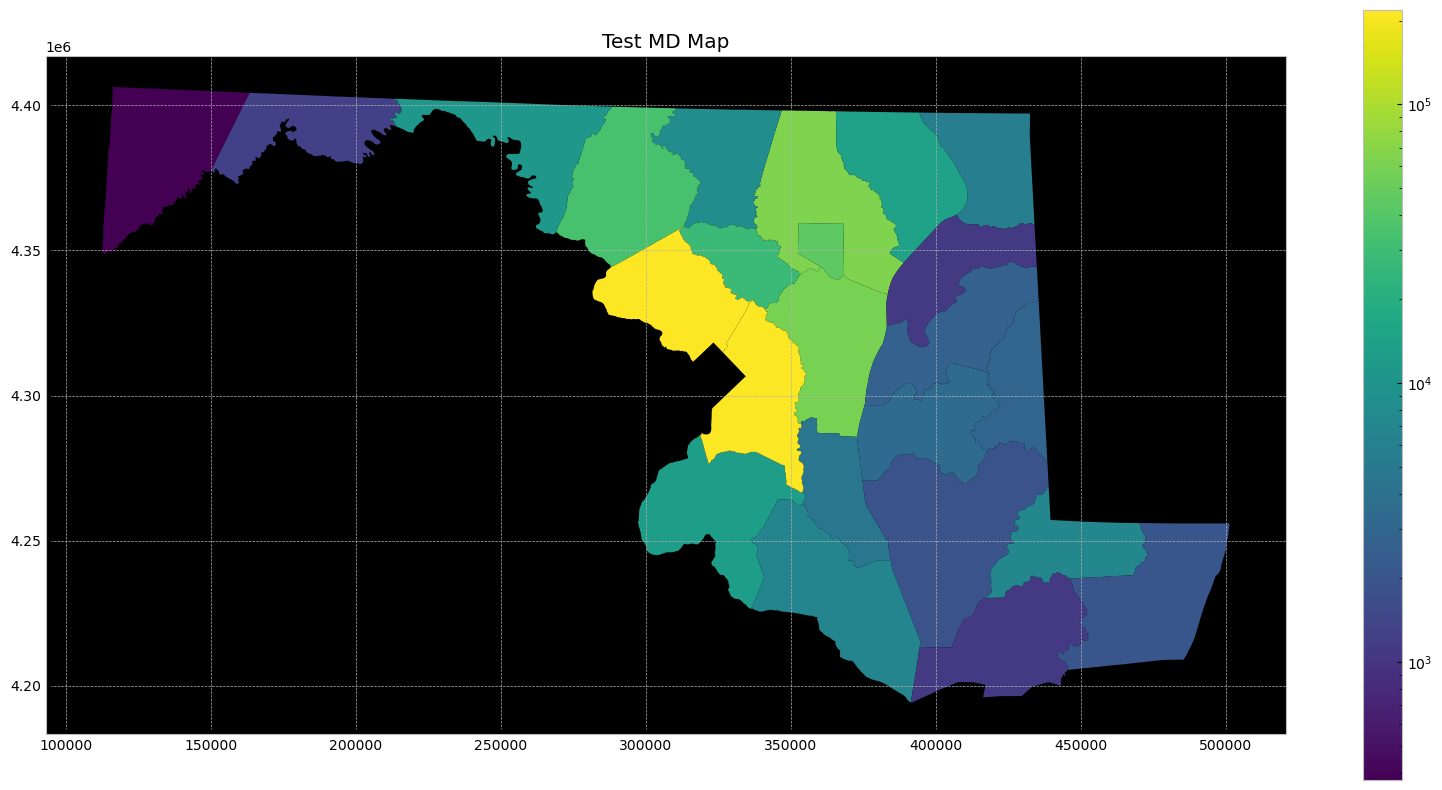

In [181]:
#Plotting to see if this works?
from matplotlib.colors import LogNorm

fig,ax = plt.subplots(1,1,figsize= (20,10))

md_demo_county.plot(column = "ethnic_hispanic",
              ax = ax,
              cmap = "viridis",
              norm =LogNorm(),
              legend = True)
plt.style.use('bmh')
ax.set_title('Test MD Map')
ax.set_facecolor('xkcd:black')

In [183]:
#Okay, let's write an output table
md_demo_county_final = pd.concat([md_demo_county, md_demo_county.iloc[:,5:]], axis = 1)

# Get all column names
cols = md_demo_county_final.columns.tolist()

# Rename columns at index 25 and onward by adding a suffix
cols[:25] = cols[:25]  
cols[25:] = [f"{col}_pct" for col in cols[25:]]

# Assign back to the DataFrame
md_demo_county_final.columns = cols

#Okay, now actually make those columns shares instead of counts
cols_to_update = md_demo_county_final.columns[25:]
md_demo_county_final[cols_to_update] = md_demo_county_final[cols_to_update].div(md_demo_county_final['total'], axis = 0)

print(md_demo_county_final.columns)
print(md_demo_county_final.head(2))
print(md_demo_county_final.dtypes)

Index(['geometry', 'STATEFP', 'TRACTCE', 'GEOID', 'NAME_y', 'total', 'age_0-4',
       'age_10-19', 'age_20-29', 'age_30-39', 'age_40-49', 'age_5-9',
       'age_50-59', 'age_60-64', 'age_65+', 'ethnic_hispanic', 'gender_female',
       'gender_male', 'race_american_indian', 'race_asian', 'race_black',
       'race_multirace', 'race_other', 'race_pacific_islander', 'race_white',
       'total_pct', 'age_0-4_pct', 'age_10-19_pct', 'age_20-29_pct',
       'age_30-39_pct', 'age_40-49_pct', 'age_5-9_pct', 'age_50-59_pct',
       'age_60-64_pct', 'age_65+_pct', 'ethnic_hispanic_pct',
       'gender_female_pct', 'gender_male_pct', 'race_american_indian_pct',
       'race_asian_pct', 'race_black_pct', 'race_multirace_pct',
       'race_other_pct', 'race_pacific_islander_pct', 'race_white_pct'],
      dtype='object')
                                                                                 geometry  \
COUNTYFP county_name                                                                  

In [187]:
#Output the final table as a csv
md_demo_county_final.drop(['geometry', 'STATEFP','TRACTCE','GEOID','NAME_y'], axis=1).to_csv('ACS 2023 MD County Data.csv', index = True)